In [1]:
import os

os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"

import torch, requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:



def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Inpainting需要用到的图片
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)


# 载入管线
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
).to(device)
pipe.enable_attention_slicing()
generator = torch.Generator(device=device).manual_seed(42)
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",
    negative_prompt="Oversaturated, blurry, low quality",
    height=480,
    width=640,
    guidance_scale=8,
    num_inference_steps=35,
    generator=generator,
)

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
100%|██████████| 35/35 [00:03<00:00, 10.64it/s]


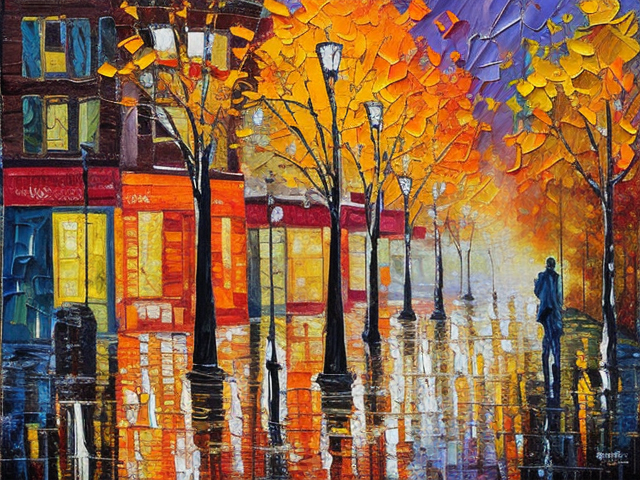

In [3]:
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:01<00:00, 18.29it/s]


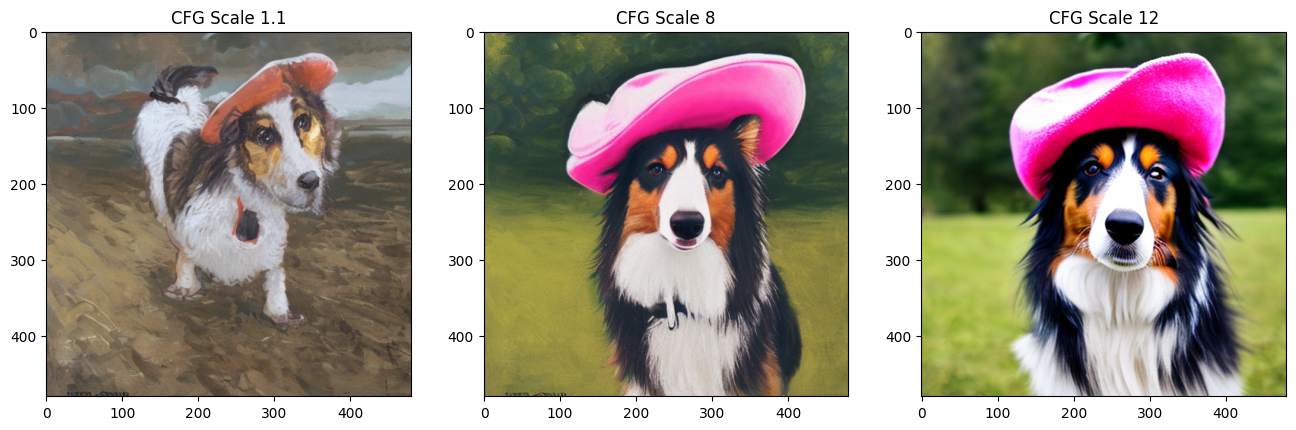

In [5]:
cfg_scales=[1.1,8,12]
prompt="A collie with a pink hat"
fig,axs=plt.subplots(1,len(cfg_scales),figsize=(16,5))
for i,ax in enumerate(axs):
    im=pipe(prompt,height=480,width=480,guidance_scale=cfg_scales[i],num_inference_steps=35,generator=torch.Generator(device=device).manual_seed(42)).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")